In [1]:
%%capture
!pip install transformers diffusers accelerate

In [2]:
%%capture
!pip install git+https://github.com/facebookresearch/segment-anything.git

In [27]:
%%capture
import torch
from diffusers import DiffusionPipeline
from diffusers import StableDiffusionInpaintPipeline
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import numpy as np
import gc
import os
from IPython.display import display, Video
from segment_anything import SamPredictor, sam_model_registry
from matplotlib.patches import Rectangle
from transformers import AutoProcessor, Owlv2ForObjectDetection
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

In [4]:
!mkdir -p {os.getcwd()}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {os.getcwd()}/weights

In [5]:
IMAGE_PATH = './deo.jpg'

# **Zero Shot object detector**

Due to lack of pre-trained object detection model that covers all the mentioned classes of the assignment, we leverage zero-shot object detector to get the bounding box of our object. The detector used here - https://huggingface.co/google/owlv2-base-patch16-ensemble


In [ ]:
class ObjectDetector():

  def __init__(self,image_path,class_):
    self.image = Image.open(image_path)
    self.class_ = class_
    self.processor = AutoProcessor.from_pretrained("google/owlv2-base-patch16-ensemble")
    self.model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble").to(device="cuda" if torch.cuda.is_available() else "cpu")

  def detect_object(self):
    '''
    Detect the object using the zero-shot object detector.

    '''

    # text prompt that contains class name so that it can form a bbox accordingly
    # providing one prompt for as we are passing only one 1 image
    text = [f"a photo of a {self.class_}"]

    inputs = self.processor(text=text, images=self.image, return_tensors="pt").to(device="cuda" if torch.cuda.is_available() else "cpu")

    # forward pass
    with torch.no_grad():
        outputs = self.model(**inputs)

    target_sizes = torch.Tensor([self.image.size[::-1]])
    # Convert outputs (bounding boxes and class logits) to final bounding boxes and scores
    results = self.processor.post_process_object_detection(
        outputs=outputs, threshold=0.2, target_sizes=target_sizes
    )

    return results

  def get_bbox(self):

    results = self.detect_object()
    boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]

    max_score_index = np.argmax(scores)

    box = [round(i, 2) for i in boxes[max_score_index].tolist()]

    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min

    # Create rectangle object with color based on confidence score (optional)
    plt.imshow(self.image)
    plt.axis('off')
    plt.title("Detected bounding box")
    color = 'green'
    rectangle = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color, facecolor='none')

    # Add rectangle to the plot
    plt.gca().add_patch(rectangle)
    return box


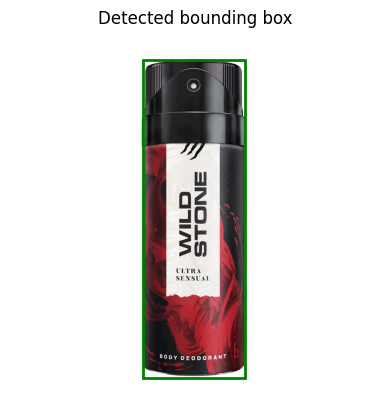

In [ ]:
obj_detector = ObjectDetector(IMAGE_PATH,"deo")
bbox = obj_detector.get_bbox()

# **SAM**

Get the mask of the object with SAM with the bbox obtained from the object detector for inpainting.

In [7]:
class SAM:
    def __init__(self, model_path, image_path, bbox):
        self.image = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        self.bbox = np.array(bbox)
        self.model_path = model_path

    def load_sam(self):
        '''
        Load the SAM model
        '''
        # Consider model optimization (quantization, pruning) for smaller size
        sam = sam_model_registry["vit_h"](checkpoint=self.model_path)
        sam = sam.to(device="cuda" if torch.cuda.is_available() else "cpu")
        return sam

    def _predict(self):
        '''
        Predict the mask using the SAM model
        '''
        sam = self.load_sam()
        mask_predictor = SamPredictor(sam)

        mask_predictor.set_image(self.image)
        masks, scores, logits = mask_predictor.predict(box=self.bbox, multimask_output=True)

        del sam

        mask_areas = [np.sum(mask) for mask in masks]
        max_area_index = np.argmax(mask_areas)
        object_masks = [mask for i, mask in enumerate(masks) if i == max_area_index]

        mask = np.zeros(self.image.shape[:2], dtype=np.uint8)

        for predicted_mask in object_masks:
            mask = np.logical_or(mask, predicted_mask)

        mask = ~mask
        mask = mask.astype(np.uint8) * 255

        return mask

    def get_mask(self):
        mask = self._predict()
        return mask

In [8]:
CHECKPOINT_PATH = os.path.join(os.getcwd(), "weights", "sam_vit_h_4b8939.pth")

sam = SAM(CHECKPOINT_PATH,IMAGE_PATH,bbox)
mask = sam.get_mask()

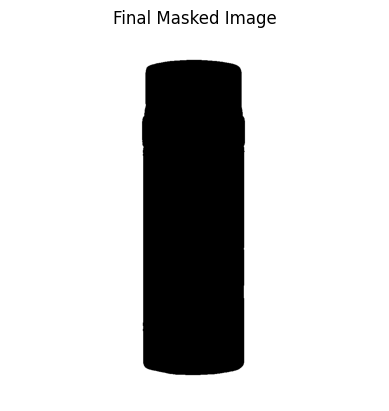

In [9]:
plt.imshow(mask,cmap='gray')
plt.title("Final Masked Image")
plt.axis("off")
plt.show()

# Inpainting

Using the masked image of our object send it to inpainting pipelne with the prompt to achieve the final result

In [18]:
class Inpaint:
  def __init__(self,image_path,mask,prompt):
    self.image = Image.open(image_path)
    self.mask = mask
    self.prompt = prompt

  def _inpaint(self):
    '''
    Inpaint the image using the SAM mask
    '''
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    variant="fp16",
    torch_dtype=torch.float16
    )
    pipe.to(device="cuda" if torch.cuda.is_available() else "cpu")
    inpainted_image = pipe(prompt=self.prompt,image=self.image,mask_image=self.mask).images[0]

    del pipe

    original_image_shape = self.image.size
    inpainted_image = inpainted_image.resize(original_image_shape)
    return inpainted_image

  def get_inpainted_image(self):
    res = self._inpaint()
    return res


In [25]:
prompt = "product placed on top a chopped trunck with a lake and trees visible in the background picture"
inpaint_obj = Inpaint(IMAGE_PATH,mask,prompt)
res = inpaint_obj.get_inpainted_image()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

(-0.5, 999.5, 999.5, -0.5)

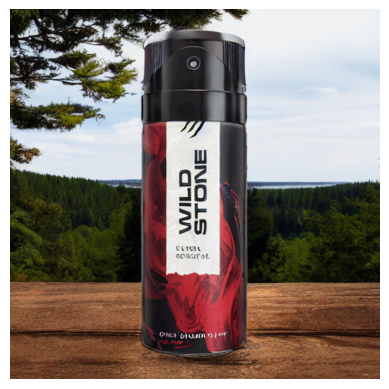

In [26]:
plt.imshow(res)
plt.axis("off")

# Convert an Image to Video

Additional code that can be used to convert a generated image from above to 3-4 sec video

In [1]:
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-video-diffusion-img2vid",torch_dtype=torch.float16, variant="fp16")
pipeline = pipeline.to("cuda" if torch.cuda.is_available() else "cpu")


from diffusers.utils import load_image, export_to_video
image = load_image('./generated_car.png')

generator = torch.manual_seed(42)

frames = pipeline(image, decode_chunk_size=8, generator=generator).frames[0]
export_to_video(frames, "generated.mp4", fps=7)